# Movies plot multi-label classification

## Load data

In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import json
import matplotlib.pyplot as plt 
from wordcloud import WordCloud
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tqdm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [2]:
from data_preparation import read_data, dict_modification, clean_text
from plotting import freq_words

In [3]:
df = read_data('../data/train.json')
df

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [01:01<00:00, 486.43it/s]


,languages,genres,title,release_date,countries,movie_box_office_revenue,plot_summary,feature_length
0,[Tamil Language],[Drama],Periya Idathu Penn,1963,[India],,Murugappa is a small time farm labourer who lives with his widowed sister Gangamma in a village. Pillaival is the zamindar of the village and Sabapathy and Punitha are his children. Punitha is studying in college in a nearby town while Sabapathy is not educated. Both the father and the child...,
1,[English Language],"[Thriller, Mystery, Crime Fiction, Drama, Crime Thriller]",The Flock,2007,[United States of America],,"A hyper-vigilant agent of the Department of Public Safety Erroll Babbage checks on registered sex offenders. Burnt out after a long career, he has become frustrated with the system of sex offender monitoring. With little faith in humanity left he takes on one last job to find a missing girl . H...",96.0
2,[Hindi Language],"[Action, Drama]",Gang,2000-04-14,[India],,"Four friends- Gangu , Abdul , Nihal and Gary - get together to start their business, but their roots are built on friendship and trust. They succeed in their criminal goals, although Gangu is arrested and sentenced to jail for five years. Before going to jail, he asks them to promise to go stra...",
3,"[Tagalog language, Filipino language, English Language]","[LGBT, Drama, Filipino Movies, World cinema]",Daybreak,2008-02-20,[Philippines],,"A married man is having an affair with another man. After some time apart, the two men spend a night together in a family vacation home in Taal, Batangas. Together in such close quarters, the two are left with nothing to do but to confront the realities of their relationship. The movie opens wit...",85.0
4,[English Language],"[Romantic comedy, Romance Film, Indie, Comedy]",Tomboy,1985-01-25,[United States of America],14100000,"The movie concerns the life of Tomasina ""Tommy"" Boyd who works as a mechanic and her hopes to become a stock car driver.\n",91.0
...,...,...,...,...,...,...,...,...
29995,[English Language],[Drama],-30-,1959,[United States of America],,"Managing Editor Sam Gatlin arrives in the afternoon and leaves early the next morning, having put together a morning newspaper for Los Angeles. During the active day in the life of a big city newspaper, Sam and his wife Peggy argue about adopting a child named Billy. A reporter's grandson pilots...",88.0
29996,[Italian Language],[Black-and-white],Ro.Go.Pa.G.,,"[France, Italy]",,"Illibatezza by Roberto Rossellini is a story of a beautiful stewardess which attracts unwanted attention from one of the air travellers - a middle aged American. The two overnight by chance in the same hotel. She has a fiance back home, to whom she sends video recordings made with her portable...",122.0
29997,[English Language],"[Crime Fiction, Thriller, Drama, Crime Thriller]",Boulevard,1994,"[United States of America, Canada]",,"The film is about a woman named Jennefer who runs from her abusive husband, gives her baby up for adoption and ends up on the streets during a grim and cold winter in Toronto. She's taken in by a prostitute named Ola . Ola sees her pimp Hassan murder another prostitute but refuses to testify a...",95.0
29998,[English Language],[Black-and-white],You Don't Know What You're Doin'!,1931-10-21,[United States of America],,"The story involves the character Piggy, who picks up his girlfriend and takes her to a theater where a hot jazz orchestra is playing. Piggy mocks the trumpet soloist, and plays a corny chorus of the 1873 hit ""Silver Threads Among the Gold"" on the saxophone. The audience, led by three drunk dogs ...",


Generating the ProfileReport for the dataset

In [4]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title='Pandas Profiling Report')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Dataset cleaning & EDA

Drop NaN-s

In [5]:
df = df[df['languages'].isna() == False]

### Genres analysis

Let's analyze film genres since it is the target variable

In [6]:
def rename_genres(init_list):
    new_list = []
    for elem in init_list:
        elem_modif = elem.lower().replace(' ', '_').replace('-', '_').replace('/', '_')
        new_list.append(elem_modif)
    return new_list

df['genres'] = df['genres'].apply(lambda x: rename_genres(x))

genres_list = []
for val in tqdm.tqdm(df['genres'].values):
    for elem in val:
        genres_list.append(elem)

len(set(genres_list)), len(genres_list)

100%|███████████████████████████████████████████████████████████████████████| 29922/29922 [00:00<00:00, 563248.77it/s]


(356, 106533)

There are 356 different genres, let's analyse their distribution and the less popular genres

In [7]:
all_genres = nltk.FreqDist(genres_list) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()),
                              'Count': list(all_genres.values())})

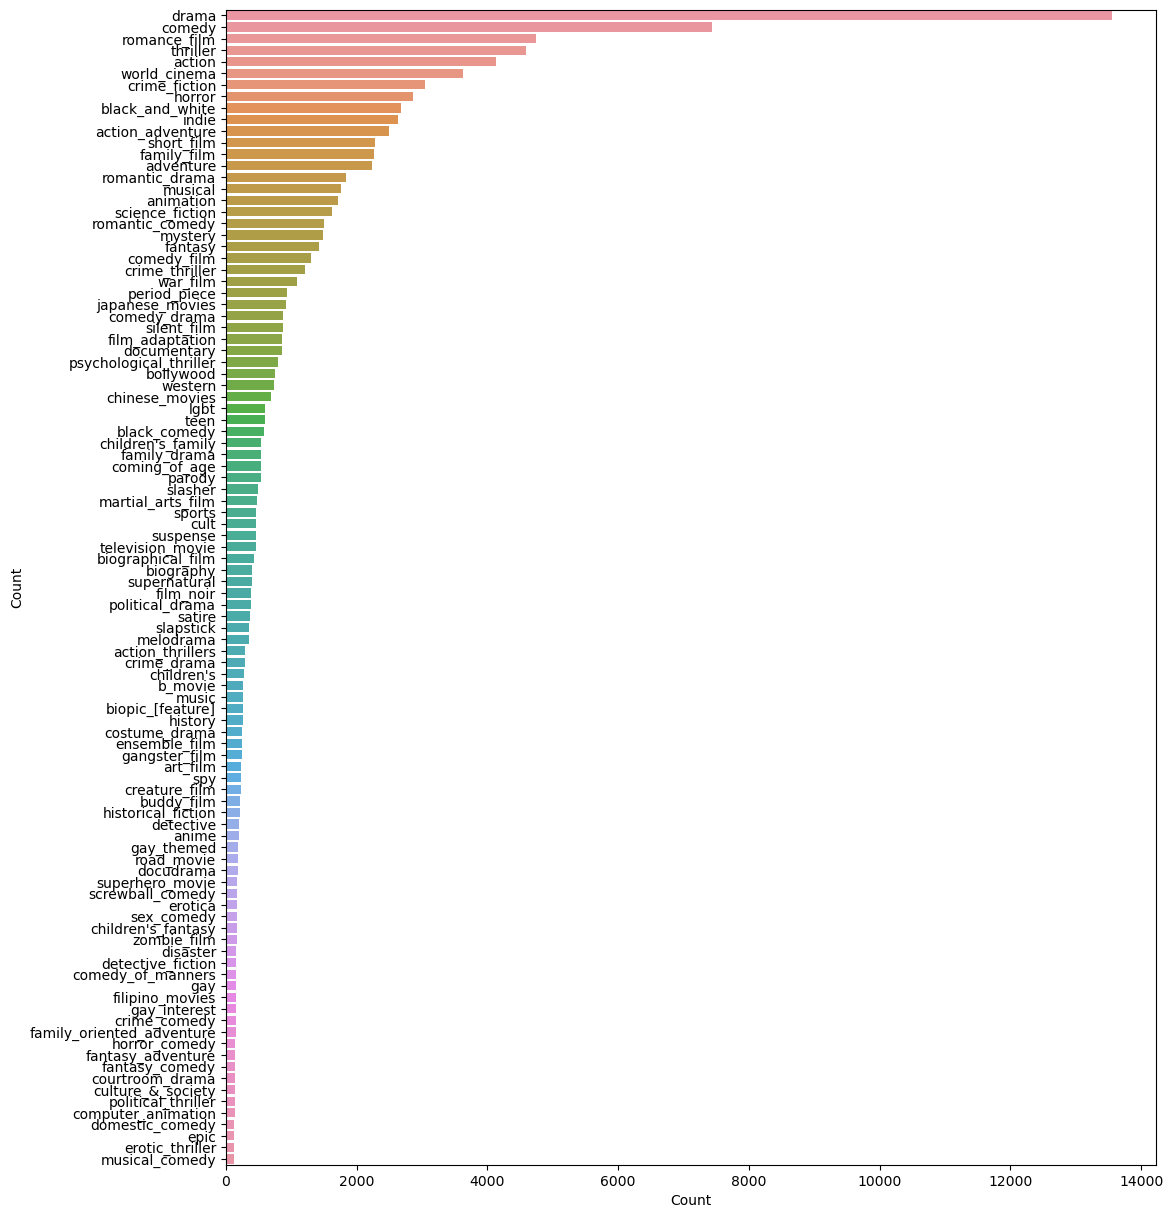

In [8]:
g = all_genres_df.nlargest(columns="Count", n = 100) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

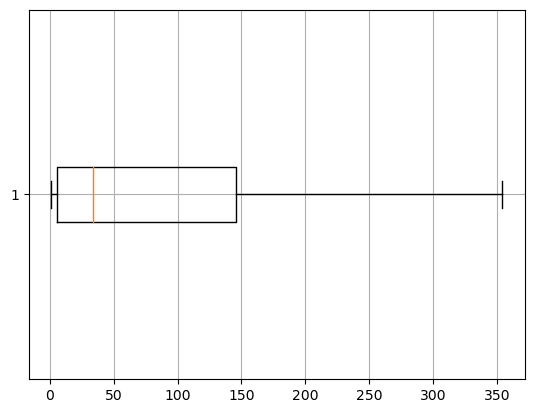

In [9]:
plt.boxplot(all_genres_df['Count'].values, vert=False, showfliers=False)
plt.grid()

(0.0, 1000.0)

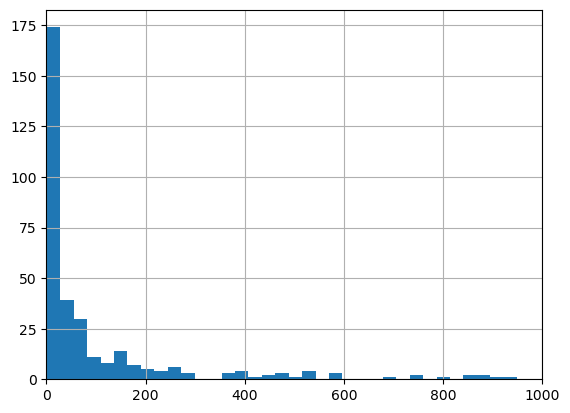

In [10]:
all_genres_df['Count'].hist(bins=500)
plt.xlim(0,1000)

Based on the distribution of genre counts, there are numerous genres with low occurrences. This implies that the model may have difficulty accurately predicting them

In [11]:
all_genres_df.query('Count < 5')

,Genre,Count
64,sponsored_film,4
137,supermarionation,1
142,singing_cowboy,2
194,point_of_view_shot,2
202,chick_flick,1
...,...,...
351,revisionist_fairy_tale,1
352,latino,1
353,patriotic_film,1
354,tokusatsu,1


Out of the total of 356 different genres, 74 of them (21%) have an occurrence of less than 5 times. This indicates that we will inaccurately predict at least 21% of the labels

### Plot summary analysis

To begin with, let's eliminate punctuation symbols and convert all letters to lowercase

In [12]:
df['clean_plot'] = df['plot_summary'].apply(lambda x: clean_text(x))

In [13]:
df[['plot_summary', 'clean_plot']].head(3)

,plot_summary,clean_plot
0,Murugappa is a small time farm labourer who lives with his widowed sister Gangamma in a village. Pillaival is the zamindar of the village and Sabapathy and Punitha are his children. Punitha is studying in college in a nearby town while Sabapathy is not educated. Both the father and the child...,murugappa is a small time farm labourer who lives with his widowed sister gangamma in a village pillaival is the zamindar of the village and sabapathy and punitha are his children punitha is studying in college in a nearby town while sabapathy is not educated both the father and the children are...
1,"A hyper-vigilant agent of the Department of Public Safety Erroll Babbage checks on registered sex offenders. Burnt out after a long career, he has become frustrated with the system of sex offender monitoring. With little faith in humanity left he takes on one last job to find a missing girl . H...",a hyper vigilant agent of the department of public safety erroll babbage checks on registered sex offenders burnt out after a long career he has become frustrated with the system of sex offender monitoring with little faith in humanity left he takes on one last job to find a missing girl he is t...
2,"Four friends- Gangu , Abdul , Nihal and Gary - get together to start their business, but their roots are built on friendship and trust. They succeed in their criminal goals, although Gangu is arrested and sentenced to jail for five years. Before going to jail, he asks them to promise to go stra...",four friends gangu abdul nihal and gary get together to start their business but their roots are built on friendship and trust they succeed in their criminal goals although gangu is arrested and sentenced to jail for five years before going to jail he asks them to promise to go straight to which...


Let's look at 100 most frequent words

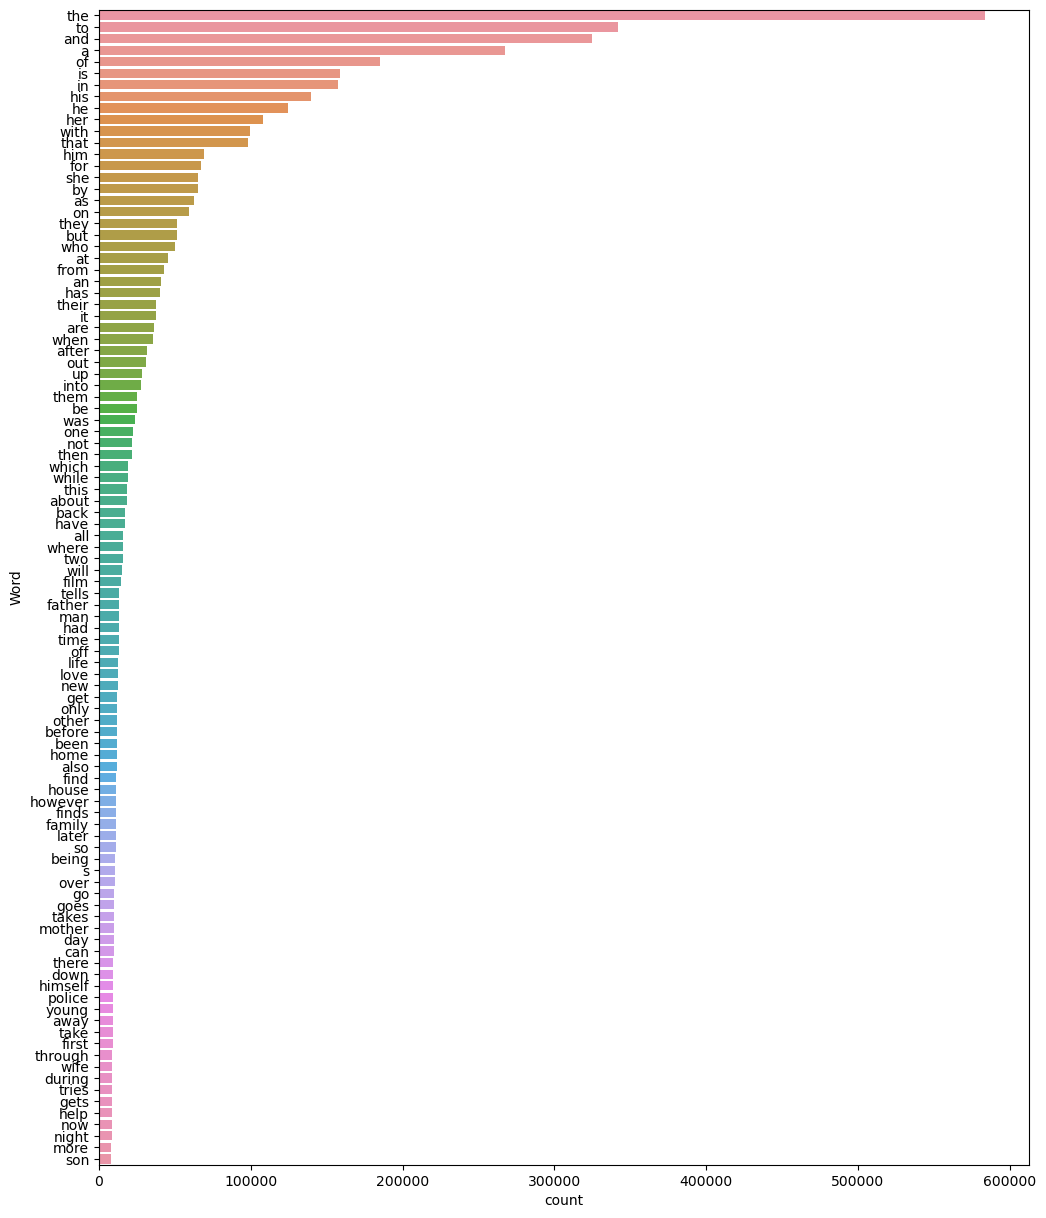

In [14]:
freq_words(df['clean_plot'].values, 100)

We observe the presence of numerous stop words (such as "the," "to," "and," etc.). Therefore, let's remove them

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nm.gavrikova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

df['clean_plot'] = df['clean_plot'].apply(lambda x: remove_stopwords(x))

And let's look at 100 most frequent words now

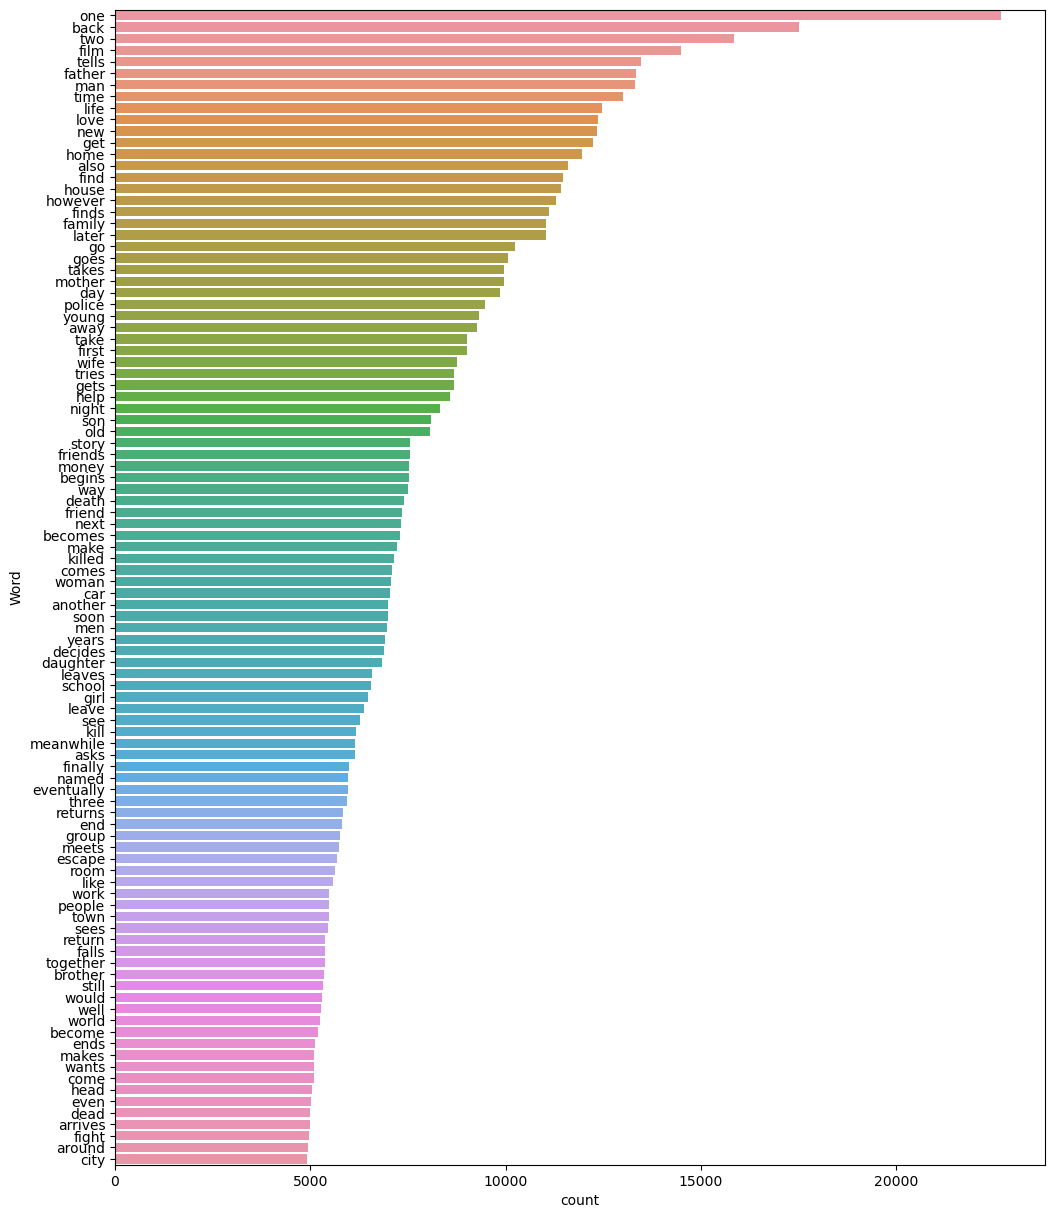

In [17]:
freq_words(df['clean_plot'].values, 100)

We should analyze the lengths of plot summaries

In [18]:
df['plot_len'] = df['clean_plot'].apply(lambda x: len(x.split(' ')))

<AxesSubplot:>

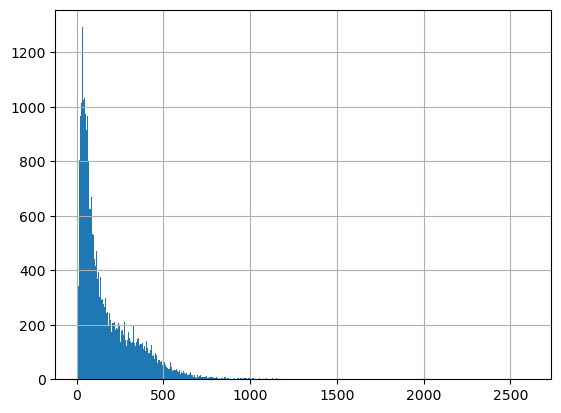

In [19]:
df['plot_len'].hist(bins=500)

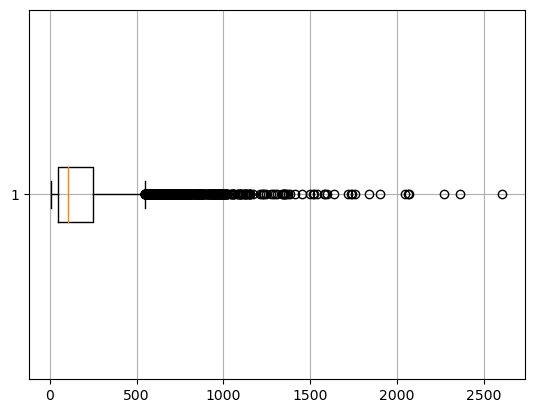

In [20]:
plt.boxplot(df['plot_len'].values, vert=False)#, showfliers=False)
plt.grid()

In [21]:
Q1 = df['plot_len'].quantile(0.25)
Q3 = df['plot_len'].quantile(0.75)
IQR = Q3 - Q1
Q_min = max(0, Q1-1.5*IQR)
Q_max = Q3+1.5*IQR

print('min_value = {}, max_value = {}\nQ_min = {}, Q1 = {}, Q3 = {}, Q_max = {}'.format(df['plot_len'].min(), df['plot_len'].max(),
                                                    Q_min, Q1, Q3, Q_max))

min_value = 7, max_value = 2605
Q_min = 0, Q1 = 49.0, Q3 = 248.0, Q_max = 546.5


In [22]:
df.query('plot_len < 10')

,languages,genres,title,release_date,countries,movie_box_office_revenue,plot_summary,feature_length,clean_plot,plot_len
2075,[Spanish Language],[comedy_film],Los Días calientes,1966,[Argentina],,This is the story of a woman who travels to the islands on the delta of the Parana River to fight for her inheritance.\n,95.0,story woman travels islands delta parana river fight inheritance,9
2843,[],"[romance_film, comedy_film]",The Amorous Adventures of Moll Flanders,,[United Kingdom],,A bawdy story of how a poor damsel surrenders her virtue again and again to get to the top of society.\n,126.0,bawdy story poor damsel surrenders virtue get top society,9
3382,[Hindi Language],"[musical, drama, bollywood, world_cinema]",Meharbaan,1993,[India],,"Meherbaan is the story of a family man, who has to decide between commitment, ethics and love between his 2 women.\n",135.0,meherbaan story family man decide commitment ethics love women,9
6385,[],"[thriller, drama]",Mother,1985-11-01,[South Korea],,"After the rape and subsequent suicide of a college student, her mother takes revenge on those responsible.\n",100.0,rape subsequent suicide college student mother takes revenge responsible,9
7475,[English Language],"[silent_film, drama, romance_film]","Love, Life and Laughter",1923-06,[United Kingdom],,"An impoverished author and a cabaret girl each have their dream of success, but are happy to wake to each other and reality.\n",,impoverished author cabaret girl dream success happy wake reality,9
8864,"[Silent film, English Language]","[silent_film, indie, black_and_white, short_film, comedy, slapstick]",Putting Pants on Philip,1927-12-03,[United States of America],,Piedmont Mumblethunder is embarrassed at the effeminacy of his kilt-wearing Scottish nephew Philip .\n,19.0,piedmont mumblethunder embarrassed effeminacy kilt wearing scottish nephew philip,9
10154,[English Language],"[pre_code, melodrama, drama, suspense, courtroom_drama]",The Kiss Before the Mirror,1933,[United States of America],,A lawyer realizes that his own wife might be having an affair while he defends a cuckolded wife-killer.\n,67.0,lawyer realizes wife might affair defends cuckolded wife killer,9
12108,[],[drama],The Crucifix,1934-03,[],,An elderly woman hires a young aide to care for her and terrorizes her with her unreasonable demands.\n,,elderly woman hires young aide care terrorizes unreasonable demands,9
12751,[English Language],"[jungle_film, adventure]",Tarzan's Deadly Silence,1970-07,[United States of America],,"Tarzan loses his hearing after a bomb blast, and is hunted through the jungle by the ruthless Colonel.\n",88.0,tarzan loses hearing bomb blast hunted jungle ruthless colonel,9
15129,[],"[romantic_drama, romance_film, drama]",Army Girl,1938-08-11,[United States of America],,Cavalry horses are in danger of being replaced by tanks resulting in a battle between machines and beasts.\n,80.0,cavalry horses danger replaced tanks resulting battle machines beasts,9


We observe significant variations in the lengths of the plot descriptions. Let's calculate a length parameter, categorizing them as very small, medium small, medium large, or very large. Considering this parameter might be helpful in stratifying the test and train samples

In [23]:
def plot_len_type(x):
    if x < Q1:
        return 0
    elif x < Q3:
        return 1
    elif x < Q_max:
        return 2
    else:
        return 3
    
df['plot_len_type'] = df['plot_len'].apply(lambda x: plot_len_type(x))
df.groupby(['plot_len_type'])[['plot_len']].count()

,plot_len
plot_len_type,
0,7358
1,15065
2,6438
3,1061


# Data encoding

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import pickle
import time

In [25]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['genres'])

# transform target variable
y = multilabel_binarizer.transform(df['genres'])

We have various options for converting the dataset into numerical vectors, such as Bag of Words, TF-IDF, Word2Vec, TF-IDF weighted Word2Vec, and more. Let's utilize the TF-IDF technique, as it is relatively simple to implement and provides a good baseline.

For this purpose, we will consider several parameters:
* max_df - a threshold that ignores terms with a document frequency higher than it
* max_features - the maximum number of words in the vocabulary, ordered by term frequency, that will be considered
* ngram_range - the option to use N-grams, which can further enhance our text featurization and improve the accuracy of our model

In [26]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=30000, ngram_range=(1,4))

In [27]:
# split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(df['clean_plot'], y, test_size=0.2, random_state=9, stratify=df['plot_len_type'])
X_train.index = range(len(X_train.index))
X_test.index = range(len(X_test.index))

In [28]:
# create TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [29]:
X_train_tfidf.shape

(23937, 30000)

In [30]:
with open('./models/vectorizer.pk', 'wb') as fin:
    pickle.dump(tfidf_vectorizer, fin)
with open('./models/multilabel_binarizer.pk', 'wb') as fin:
    pickle.dump(multilabel_binarizer, fin)

We should analyze the effectiveness of word encoding.

We can calculate two values:
* plot_size - the number of words in the plot summary.
* enc_words_size - the number of words from the summary that were successfully encoded.

The ratio enc_words_size / plot_size reflects the quality of the encoding process, representing the share of words from the movie's plot that appeared in the encoded train dataset. In our case, we can observe that less than half of all words may be lost. Additionally, it is important to note that there are no cases where plots were not encoded.

In [31]:
plot_size = []
enc_words_size = []
ratio_list = []
for i in tqdm.tqdm(range(X_train_tfidf.shape[0])):
    plot_size.append(len(X_train[i].split(' ')))
    enc_words_size.append((X_train_tfidf[i] != 0).size)
    ratio_list.append((X_train_tfidf[i] != 0).size / len(X_train[i].split(' ')))

100%|█████████████████████████████████████████████████████████████████████████| 23937/23937 [00:10<00:00, 2316.42it/s]


min ratio = 0.25333333333333335 , mean ratio = 0.8453635748253726


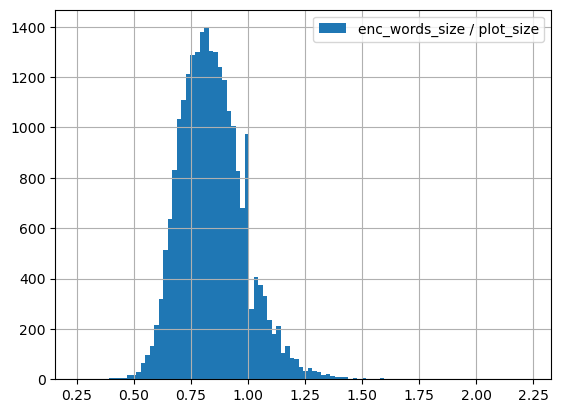

In [32]:
print('min ratio =', np.min(ratio_list), ', mean ratio =', np.mean(ratio_list))
plt.hist(ratio_list, bins=100, label='enc_words_size / plot_size')
plt.grid()
plt.legend()

We may conclude that our word encoding procedure is representative enought

# Model training

Let's explore the problem we address and potential methods to tackle it. We are focused on solving the Multi-label Classification task, which is a variation of the classification problem where instances can be assigned multiple nonexclusive labels. This problem extends the concept of multiclass classification, where instances are categorized into a single class from several available options. In multi-label classification, there are no restrictions on the number of labels an instance can be assigned to, and the labels are nonexclusive.

To address this task, there are various approaches available. Considering our goal is not to achieve the best possible metrics due to time constraints, let's consider the OneVsRest approach. This intuitive method decomposes the multi-label problem into multiple independent binary classification problems, with each problem focusing on one category. In a "one-to-rest" strategy, we can build multiple independent classifiers and, when dealing with a new instance, select the class for which the confidence is maximized.

During further investigation, we can explore alternative approaches and also attempt to find optimal model parameters, such as experimenting with different regularization coefficients.

In terms of evaluating the performance of the model, we should consider metrics such as the f1-score, precision, and recall. In the following discussion, we will delve into these metrics in detail.

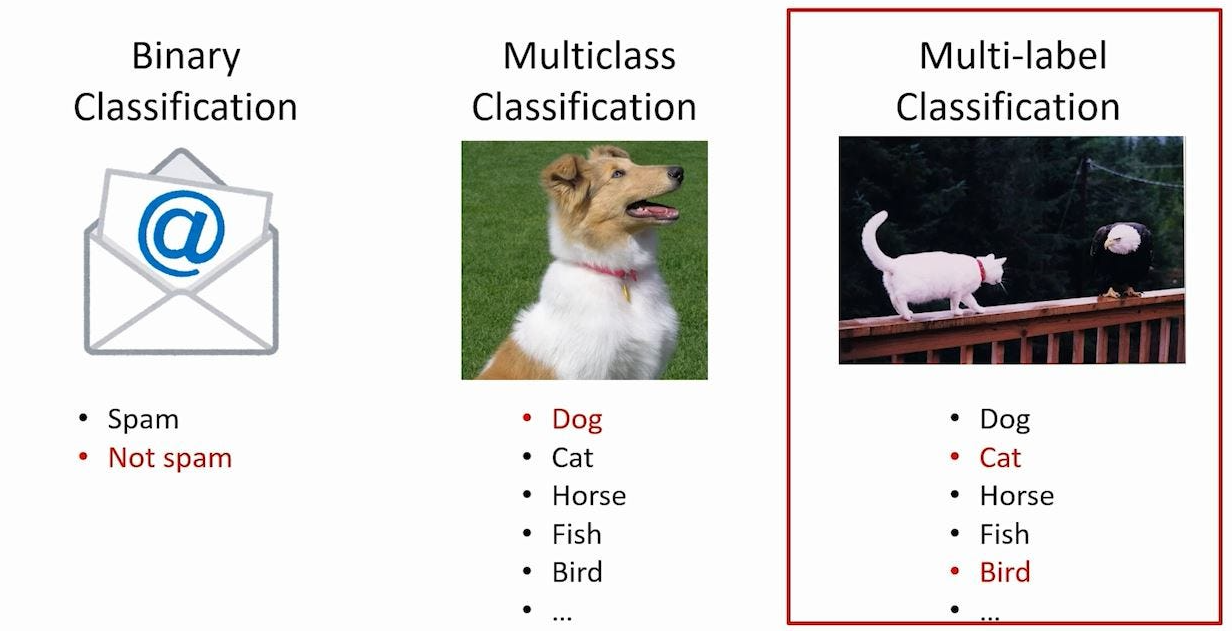
<!-- <img src=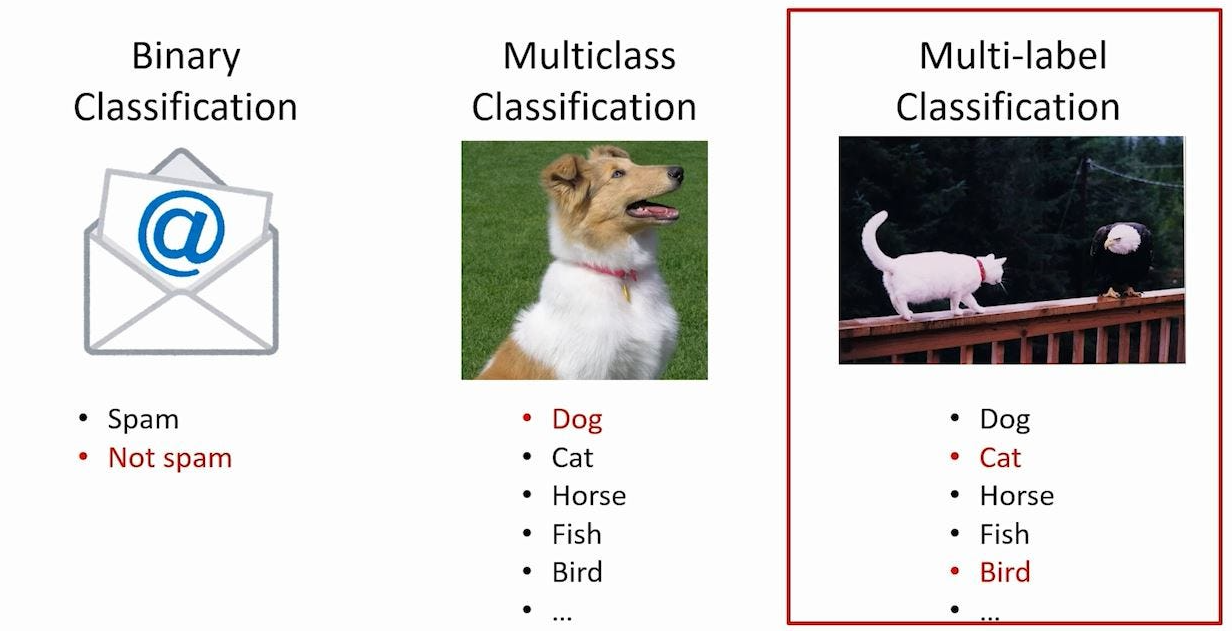 alt="Drawing" style="width: 200px;"/> -->

## Logistic Regression

Let's consider the logistic regression models

In [33]:
lr = LogisticRegression()
clf_lr = OneVsRestClassifier(lr)

In [34]:
# fit model on train data, training time about 5 minutes
start_time = time.time()
clf_lr.fit(X_train_tfidf, y_train)
end_time = time.time()
print('training time: {} min'.format((end_time - start_time)/60.))

training time: 4.209849214553833 min


In [35]:
with open('./models/model_lr.pk', 'wb') as fin:
    pickle.dump(clf_lr, fin)

Let's consider one of the predictions

In [36]:
y_pred = clf_lr.predict(X_test_tfidf)

In [37]:
y_pred[0]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [38]:
multilabel_binarizer.inverse_transform(y_pred)[0]

('action', 'crime_fiction', 'thriller')

Intuitively, precision is the ability of the classifier not to label as positive a sample that is negative, and recall is the ability of the classifier to find all the positive samples.

The F-measure can be interpreted as a weighted harmonic mean of the precision and recall: reaches its best value at 1 and its worst score at 0.

Several functions allow you to analyze the precision, recall and F-measures score.

In multiclass and multilabel classification task, the notions of precision, recall, and F-measures can be applied to each label independently.

There are a few ways to combine results across labels, specified by the average argument to the average_precision_score (multilabel only), f1_score, fbeta_score, precision_recall_fscore_support, precision_score and recall_score functions, as described above.

Note that for “micro”-averaging in a multiclass setting with all labels included will produce equal precision, recall and F, while “weighted” averaging may produce an F-score that is not between precision and recall.

Let's look at the classification report

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         1
           2       0.64      0.18      0.28       818
           3       0.65      0.06      0.11       501
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00        53
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        12
           8       0.77      0.09      0.16       446
           9       0.00      0.00      0.00        15
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00        14
          15       0.00      0.00      0.00        21
          16       0.00      0.00      0.00         2
          17       0.00    

We have a lot of classes with different frequencies, each class is unbalanced. Therefore, let's consider weighted average of f1-score as the main metric

In [40]:
# evaluate performance
f1_score(y_test, y_pred, average="weighted")

0.22159578566286256

Let's try to find an optimal probability threshold

In [41]:
# predict probabilities
y_pred_prob = clf_lr.predict_proba(X_test_tfidf)

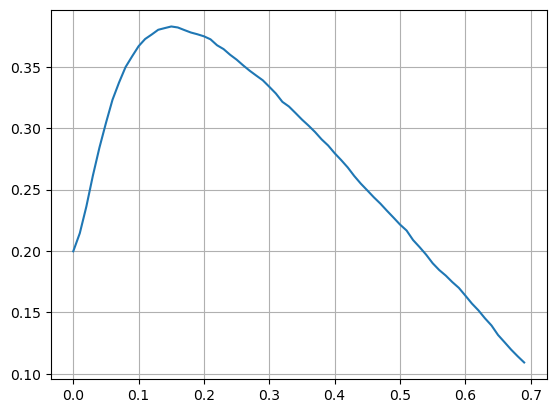

In [42]:
t_list = [i for i in np.arange(0, 0.7, 0.01)]
f1_score_list = []
for t in t_list:
    y_pred_new = (y_pred_prob >= t).astype(int)
    f1_score_list.append(f1_score(y_test, y_pred_new, average="weighted"))

plt.plot(t_list, f1_score_list)
plt.grid()

In [43]:
f1_max = max(f1_score_list)
idx = f1_score_list.index(f1_max)
t_opt = t_list[idx]

y_pred_new = (y_pred_prob >= t_opt).astype(int)

In [44]:
t_opt

0.15

The new model's performance is significantly improved, approximately twice as good as the old model. This is great!

In [45]:
# evaluate performance
print(f1_score(y_test, y_pred_new, average="weighted"))

0.3828454090943998


Let's look at the new report

In [46]:
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         1
           2       0.37      0.79      0.51       818
           3       0.36      0.63      0.46       501
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00        53
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        12
           8       0.39      0.57      0.46       446
           9       0.00      0.00      0.00        15
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00        14
          15       0.00      0.00      0.00        21
          16       0.00      0.00      0.00         2
          17       0.00    

We should keep in mind, that we have the problem with a large number of small-frequented labels. In the report we see, that with increasing of the labels frequency (parameter "support") the f1-score increase:

In [47]:
report = classification_report(y_test, y_pred_new, output_dict=True)
df_report = pd.DataFrame(report).transpose()

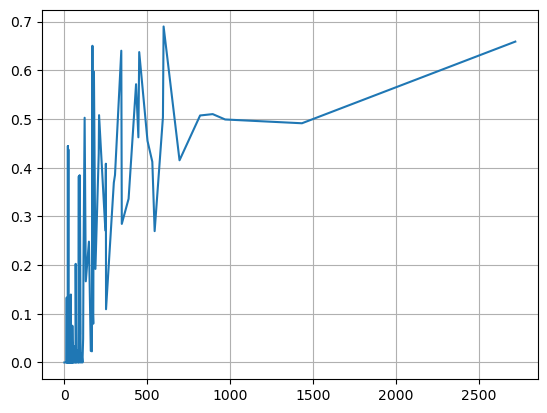

In [48]:
plt.plot(df_report.iloc[:-4].sort_values(['support'])['support'], df_report.iloc[:-4].sort_values(['support'])['f1-score'])
plt.grid()

Let's also analyse the distribution of the f1-score for different support values

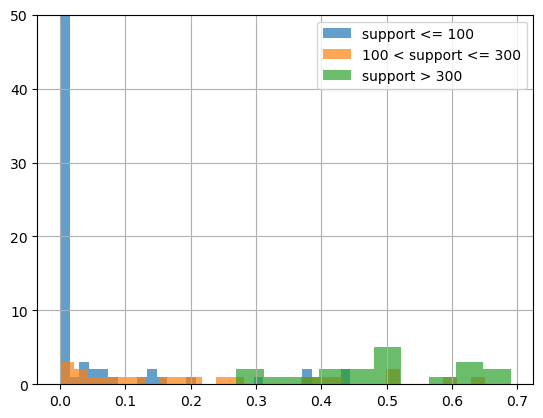

In [49]:
plt.hist(df_report.iloc[:-4].query('support <= 100')['f1-score'].values, bins=30, alpha=0.7, label='support <= 100')
plt.hist(df_report.iloc[:-4].query('support > 100 & support <= 300')['f1-score'].values, bins=30, alpha=0.7, \
         label='100 < support <= 300')
plt.hist(df_report.iloc[:-4].query('support > 300')['f1-score'].values, alpha=0.7, bins=10, label='support > 300')
plt.legend()
plt.ylim(0,50)
plt.grid()

Therefore to receive better metrics we should solve the problem with small-frequented labels. We should remove these classes or increase the number of examples of these classes

### Decision Trees

Let's try to use another model

In [50]:
dt = DecisionTreeClassifier(criterion='gini', max_depth = 5, random_state=1)
clf_dt = OneVsRestClassifier(dt)

In [51]:
# fit model on train data, training time about 10 minutes
start_time = time.time()
clf_dt.fit(X_train_tfidf, y_train)
end_time = time.time()
print('training time: {} min'.format((end_time - start_time)/60.))

training time: 11.731984659036 min


In [52]:
with open('./models/model_dt.pk', 'wb') as fin:
    pickle.dump(clf_dt, fin)

In [53]:
y_pred = clf_dt.predict(X_test_tfidf)

Let's consider one of the predictions

In [54]:
y_pred[0]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [55]:
multilabel_binarizer.inverse_transform(y_pred)[0]

('action', 'drama', 'teen', 'thriller')

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         1
           2       0.52      0.09      0.16       818
           3       0.33      0.04      0.06       501
           4       0.00      0.00      0.00        16
           5       0.12      0.02      0.03        53
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        12
           8       0.41      0.09      0.14       446
           9       0.50      0.07      0.12        15
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         1
          12       0.12      0.10      0.11        10
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00        14
          15       0.00      0.00      0.00        21
          16       0.00      0.00      0.00         2
          17       0.50    

In [57]:
# evaluate performance
f1_score(y_test, y_pred, average="weighted")

0.17938325246539608

In [58]:
# predict probabilities
y_pred_prob = clf_dt.predict_proba(X_test_tfidf)

Let's try to find an optimal probability threshold

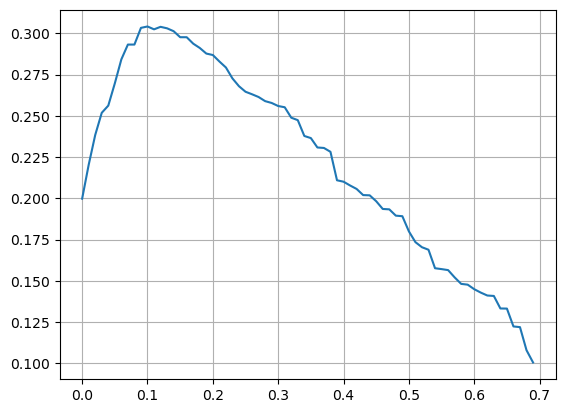

In [59]:
t_list = [i for i in np.arange(0, 0.7, 0.01)]
f1_score_list = []
for t in t_list:
    y_pred_new = (y_pred_prob >= t).astype(int)
    f1_score_list.append(f1_score(y_test, y_pred_new, average="weighted"))

plt.plot(t_list, f1_score_list)
plt.grid()

In [60]:
f1_max = max(f1_score_list)
idx = f1_score_list.index(f1_max)
t_opt = t_list[idx]

y_pred_new = (y_pred_prob >= t_opt).astype(int)

In [61]:
t_opt

0.1

In [62]:
# evaluate performance
f1_score(y_test, y_pred_new, average="weighted")

0.30414191227909404

In [63]:
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         1
           2       0.26      0.53      0.35       818
           3       0.17      0.47      0.25       501
           4       0.00      0.00      0.00        16
           5       0.13      0.09      0.11        53
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        12
           8       0.23      0.41      0.29       446
           9       0.50      0.07      0.12        15
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         1
          12       0.12      0.10      0.11        10
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00        14
          15       0.00      0.00      0.00        21
          16       0.00      0.00      0.00         2
          17       0.50    

Therefore we can conclude, that decision tree model requires more time for training procedure and doesn't bring better metrics

# Analysis of the dependency from labels number

In conclusion, let's analyze the relationship between model performance and the number of labels.

We can start by sorting the labels based on their frequency and then train different models using subsets of these labels. To achieve this, we will need to recalculate the target values accordingly.

For example, let's consider the target values for an instance: ["silent_film", "drama", "romance_film"].

In the first model, we will focus on the top-2 labels. Since "silent_film" and "drama" are not among the top-2 labels, the new target value for this model will be ["romance_film"].

In the second model, we will include the top-5 labels. Since "silent_film" is not among the top-5 labels, the new target value for this model will be ["drama", "romance_film"].

For the third, fourth, and subsequent models, we will gradually include more labels. In this case, since ["silent_film", "drama", "romance_film"] are among the top-10, top-15, and so on labels, the new target values for the third, fourth, and subsequent models will be ["silent_film", "drama", "romance_film"].

By training and evaluating different models with varying subsets of labels, we can assess how model performance is affected by the number of labels considered. This analysis will provide insights into the relationship between label quantity and model effectiveness.

In [64]:
# requiers about 1 hour for calculations, may be uncommented
from data_preparation import calc_dependency_from_class_num
# res_df = calc_dependency_from_class_num(all_genres_df, df, 2, 10)

In [65]:
res_df = pd.read_csv('model_performance_results.csv')
res_df

,N_genres,f1_micro,precision_micro,recall_micro,f1_macro,precision_macro,recall_macro,f1_weighted,precision_weighted,recall_weighted,f1_samples,precision_samples,recall_samples
0,2,0.869364,0.808602,0.940000,0.817106,0.762840,0.879870,0.868563,0.807314,0.940000,0.885779,0.862251,0.953203
1,12,0.611264,0.520150,0.741078,0.434339,0.454921,0.499110,0.595168,0.517288,0.741078,0.602252,0.553741,0.777754
2,22,0.555760,0.475396,0.668821,0.321305,0.343237,0.357895,0.520815,0.450196,0.668821,0.543201,0.499257,0.713574
3,32,0.541910,0.461392,0.656471,0.336673,0.383516,0.367198,0.513863,0.452096,0.656471,0.523676,0.478845,0.698350
4,42,0.525951,0.468758,0.599041,0.301491,0.365934,0.313341,0.491168,0.460511,0.599041,0.501136,0.482754,0.630967
5,52,0.518401,0.447672,0.615674,0.274527,0.328919,0.291987,0.484568,0.441121,0.615674,0.494705,0.459876,0.650986
6,62,0.508655,0.443641,0.595997,0.244977,0.340805,0.254800,0.468661,0.435307,0.595997,0.483555,0.455961,0.626945
7,72,0.509613,0.453826,0.581036,0.230438,0.353284,0.233640,0.464906,0.440303,0.581036,0.486559,0.468244,0.616131
8,82,0.500522,0.461225,0.547140,0.201682,0.304469,0.199291,0.449118,0.439055,0.547140,0.475935,0.474055,0.582207
9,92,0.487586,0.428925,0.564835,0.187627,0.272848,0.194683,0.437566,0.412997,0.564835,0.464680,0.439686,0.608196


Let's look at the dependency of model performance (different f1-scores) from the number of labels (X-label)

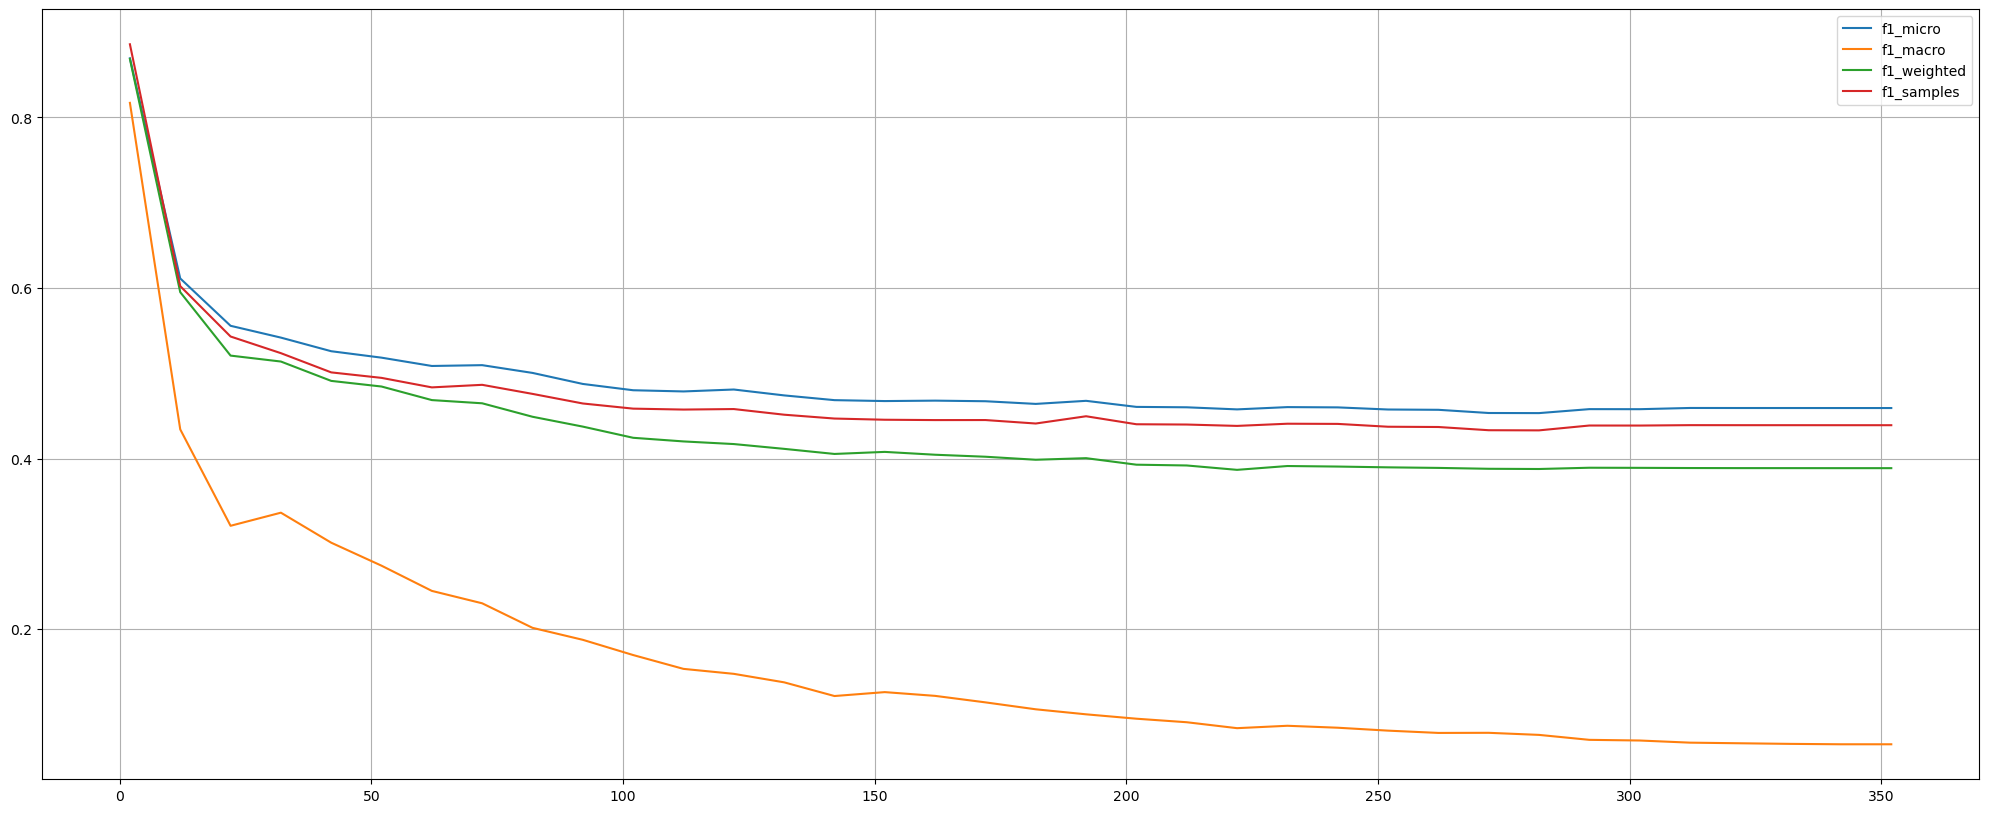

In [66]:
plt.figure(figsize=(25,10))
plt.plot(res_df['N_genres'], res_df['f1_micro'], label='f1_micro')
plt.plot(res_df['N_genres'], res_df['f1_macro'], label='f1_macro')
plt.plot(res_df['N_genres'], res_df['f1_weighted'], label='f1_weighted')
plt.plot(res_df['N_genres'], res_df['f1_samples'], label='f1_samples')
plt.grid()
plt.legend()

Based on our observations, we can deduce that once we reach a certain threshold (approximately 100) of labels, the model's metrics reach a plateau. This indicates that considering an extensive number of distinct labels is unnecessary.

# Conclusions

After conducting thorough research on the data, a multi-label classification model was developed and the following conclusions may be made:

* We identified numerous labels with low frequencies, having less than 5 examples each. Predicting these labels accurately proved challenging. Our research suggests that approximately 250 of these less-frequented labels can be removed without impacting the model's performance. Additionally, increasing the number of examples for the other classes could be beneficial.

* The length of plot descriptions varies significantly, ranging from 7 to 2605 words. To address this, we incorporated stratification during the division of the dataset into train and test sets, considering the wide range of description lengths.

* For encoding movie plots, we employed the TF-IDF technique, which offers effective representation without substantial information loss.

* As the final classification model, we opted for a combination of logistic regression models. While being relatively simple, this model serves as a reliable initial approximation for further research and analysis.

In order to further enhance our research, we should consider the following aspects:

* Exploration of more advanced techniques for word encoding. It would be beneficial to explore more complex methods for encoding words in the plot descriptions. This could involve investigating techniques such as word embeddings or neural network-based encoders to capture richer semantic information.

* Analysis of correlations between target labels and words. It would be valuable to analyze the relationships between the target labels and the words present in the plot descriptions. This analysis could potentially reveal certain words or phrases that strongly indicate specific labels. Identifying such indicators could significantly improve the accuracy of label predictions.

* Consideration of more sophisticated models. In addition to the logistic regression models and decision tree models we have utilized so far, it is worth exploring more advanced models. This could range from classic machine learning models such as random forests or gradient boosting, to more advanced architectures like recurrent neural networks (RNNs) or Transformers. These models have the potential to capture more complex patterns and dependencies in the data.

* Hyperparameter tuning. To optimize the performance of the considered models, it is essential to tune their hyperparameters. Through systematic experimentation and validation, we can identify the optimal configuration of hyperparameters that yields the best results.

By addressing these aspects in our further research, we can deepen our understanding and potentially achieve even better performance in the multi-label classification task.